In [46]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'who-is-the-real-winner:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72632%2F8059709%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T062255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Ddff84f75b6d04a120edd23e1233fe1b6b757808cd6fbf0e783c9f65e331d1e3f1a3fc21ceec539180a24a8d79a875603619c8e51e9dbfec1d703f5baaffe66ae761783ecb7cad525a8f6b01e4626cbf8171a799a1ae7317b76e1fc2d4d78bd197f52388f4baf99f4a1847d88a554a282645b92f2dca65f473fb2863c4ff690da6bde3ae2a871622a707201f89e42c7d3566df79a5e2a810432f43c2a0252da7efebc29e1c098240237adfb92a1a38ce4d8028b1492c9064b63ae24c3efe6348f12313524a164eefa2e1883212835163953d836c701c08972813a8aa8cc0f8aa4332fe05c565a3cb91b9c0cb7d11bc3339b4744c2f1a957ef60bcb8faa41318f4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 89112 bytes downloaded
Downloaded and uncompressed: who-is-the-real-winner
Data source import complete.


# Importing necessary libraries

In [47]:
import os
import re
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# Reading Data from files

In [48]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/who-is-the-real-winner/test.csv
/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv


In [49]:
train_data = pd.read_csv('/kaggle/input/who-is-the-real-winner/train.csv')
test_data = pd.read_csv('/kaggle/input/who-is-the-real-winner/test.csv')

In [50]:
train_data.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


In [51]:
test_data.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state
0,0,Geeta Bharat Jain,MEERA BHAYANDAR,IND,2,70 Crore+,11 Crore+,MAHARASHTRA
1,1,Becharam Manna,SINGUR,AITC,1,2 Crore+,13 Lac+,WEST BENGAL
2,2,Sunil Vijay Tingre,VADGAON SHERI,NCP,3,49 Crore+,1 Crore+,MAHARASHTRA
3,3,Asit Mazumder (Tapan),CHUNCHURA,AITC,1,2 Crore+,0,WEST BENGAL
4,4,Hriday Narayan Singh Patel,SAGRI,SP,0,16 Crore+,2 Crore+,UTTAR PRADESH


# Data Pre-Processing Steps

### To convert categorical values to int / float, found all unique values

In [52]:
unique_values = sorted(train_data['Total Assets'].unique())
print(unique_values)

['0', '1 Crore+', '1 Lac+', '10 Crore+', '10 Lac+', '102 Crore+', '105 Crore+', '106 Crore+', '109 Crore+', '11 Crore+', '11 Lac+', '110 Crore+', '111 Crore+', '112 Crore+', '115 Crore+', '1156 Crore+', '12 Crore+', '12 Lac+', '122 Crore+', '1267 Crore+', '128 Crore+', '13 Crore+', '13 Lac+', '134 Crore+', '135 Crore+', '138 Crore+', '14 Crore+', '14 Lac+', '141 Crore+', '15 Crore+', '15 Lac+', '15 Thou+', '159 Crore+', '16 Crore+', '16 Lac+', '163 Crore+', '17 Crore+', '17 Lac+', '18 Crore+', '18 Lac+', '18 Thou+', '183 Crore+', '187 Crore+', '189 Crore+', '19 Crore+', '19 Lac+', '191 Crore+', '2 Crore+', '2 Lac+', '20 Crore+', '20 Lac+', '21 Crore+', '21 Lac+', '211 Crore+', '22 Crore+', '22 Lac+', '23 Crore+', '23 Lac+', '24 Crore+', '24 Lac+', '24 Thou+', '242 Crore+', '25 Crore+', '25 Lac+', '26 Crore+', '26 Lac+', '27 Crore+', '27 Lac+', '274 Crore+', '28 Crore+', '28 Lac+', '29 Crore+', '29 Lac+', '293 Crore+', '296 Crore+', '3 Crore+', '3 Lac+', '30 Crore+', '30 Thou+', '31 Cro

### Function to convert assets and liabilities to numbers

In [53]:
def convert_to_float(value):
    if 'crore' in value.lower():
        return float(value.lower().replace('crore', '')) * 10000000
    elif 'lac' in value.lower():
        return float(value.lower().replace('lac', '')) * 100000
    elif 'thou' in value.lower():
        return float(value.lower().replace('thou', '')) * 1000
    elif 'hund' in value.lower():
        return float(value.lower().replace('hund', '')) * 100
    else:
        return float(value)

In [54]:
def convert_to_int(value):
    if 'crore' in value.lower():
        return int(value.lower().replace('crore', '')) * 10000000
    elif 'lac' in value.lower():
        return int(value.lower().replace('lac', '')) * 100000
    elif 'thou' in value.lower():
        return int(value.lower().replace('thou', '')) * 1000
    elif 'hund' in value.lower():
        return int(value.lower().replace('hund', '')) * 100
    else:
        return int(value)

### Removed unnecessary column (Name and ID) and cleaned 'Total Assets' and 'Liabilities'

In [55]:
train_data['Total Assets'] = train_data['Total Assets'].str.replace('+', '')
train_data['Liabilities'] = train_data['Liabilities'].str.replace('+', '')

train_data['Total Assets'] = train_data['Total Assets'].apply(convert_to_float)
train_data['Liabilities'] = train_data['Liabilities'].apply(convert_to_float)

In [56]:
test_data['Total Assets'] = test_data['Total Assets'].str.replace('+', '')
test_data['Liabilities'] = test_data['Liabilities'].str.replace('+', '')

test_data['Total Assets'] = test_data['Total Assets'].apply(convert_to_float)
test_data['Liabilities'] = test_data['Liabilities'].apply(convert_to_float)

In [57]:
train_data['Advocate'] = 0
train_data['Doctor'] = 0

train_data.loc[train_data['Candidate'].str.contains('Adv.'), 'Advocate'] = 1
train_data.loc[train_data['Candidate'].str.contains('Dr.'), 'Doctor'] = 1

In [58]:
test_data['Advocate'] = 0
test_data['Doctor'] = 0

test_data.loc[test_data['Candidate'].str.contains('Adv.'), 'Advocate'] = 1
test_data.loc[test_data['Candidate'].str.contains('Dr.'), 'Doctor'] = 1

In [59]:
train_data.drop(['ID', 'Candidate'], axis=1, inplace=True)

In [60]:
test_data.drop(['ID', 'Candidate'], axis=1, inplace=True)

## One-Hot encoding for 'State' and 'Party' columns

In [61]:
state_one_hot_train = pd.get_dummies(train_data['state'])
party_one_hot_train = pd.get_dummies(train_data['Party'])

train_data = pd.concat([train_data, state_one_hot_train, party_one_hot_train], axis=1)
for col in train_data.columns:
    train_data[col] = train_data[col].replace({False: 0, True: 1})

In [62]:
state_one_hot_test = pd.get_dummies(test_data['state'])
party_one_hot_test = pd.get_dummies(test_data['Party'])

test_data = pd.concat([test_data, state_one_hot_test, party_one_hot_test], axis=1)
for col in test_data.columns:
    test_data[col] = test_data[col].replace({False: 0, True: 1})

# Feature Engineering

### Created new feature 'Net Capital' as the difference between 'Total Assets' and 'Liabilities'

In [63]:
train_data['Net Capital'] = train_data['Total Assets']-train_data['Liabilities']

In [64]:
test_data['Net Capital'] = test_data['Total Assets']-test_data['Liabilities']

### Created another feature 'Leverage Ratio' as the ratio of 'Total Assets'/ 'Net capital'

In [65]:
median_capital = train_data['Net Capital'].median()
train_data['Leverage_Ratio'] = train_data.apply(lambda x: x['Total Assets'] / median_capital if x['Net Capital'] == 0 else x['Total Assets'] / x['Net Capital'], axis=1)

In [66]:
median_capital = test_data['Net Capital'].median()
test_data['Leverage_Ratio'] = test_data.apply(lambda x: x['Total Assets'] / median_capital if x['Net Capital'] == 0 else x['Total Assets'] / x['Net Capital'], axis=1)

### Grouped the states into various regions

In [67]:
unique_values = sorted(train_data['state'].unique())
print(unique_values)

['ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHHATTISGARH', 'DELHI', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JHARKHAND', 'KARNATAKA', 'KERALA', 'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'NAGALAND', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL']


In [68]:
region_mapping = {
    'North': ['JAMMU AND KASHMIR', 'HIMACHAL PRADESH', 'PUNJAB', 'HARYANA', 'UTTARAKHAND'],
    'South': ['ANDHRA PRADESH', 'TELANGANA', 'KARNATAKA', 'KERALA', 'TAMIL NADU'],
    'East': ['BIHAR', 'JHARKHAND', 'ODISHA', 'WEST BENGAL', 'SIKKIM'],
    'West': ['RAJASTHAN', 'GUJARAT', 'GOA', 'MAHARASHTRA'],
    'Central': ['MADHYA PRADESH', 'CHHATTISGARH', 'UTTAR PRADESH', 'DELHI'],
    'North East': ['ASSAM', 'MEGHALAYA', 'TRIPURA', 'NAGALAND', 'MANIPUR', 'MIZORAM', 'ARUNACHAL PRADESH']
}

#### Performed one-hot encoding of these regions

In [69]:
train_data['Region'] = train_data['state'].map({state: region for region, states in region_mapping.items() for state in states})
Regions_encoded = pd.get_dummies(train_data['Region'], prefix='Region')
train_data = pd.concat([train_data, Regions_encoded], axis=1)
train_data.drop('Region', axis=1, inplace=True)
for col in Regions_encoded.columns:
    train_data[col] = train_data[col].astype(int)

In [70]:
test_data['Region'] = test_data['state'].map({state: region for region, states in region_mapping.items() for state in states})
Regions_encoded = pd.get_dummies(test_data['Region'], prefix='Region')
test_data = pd.concat([test_data, Regions_encoded], axis=1)
test_data.drop('Region', axis=1, inplace=True)
for col in Regions_encoded.columns:
    test_data[col] = test_data[col].astype(int)

### Grouped Constituencies into three categories: 'SC Constituency', 'ST Constituency' and 'General Constituency'

In [71]:
def extract_constituency_type(constituency):
    match = re.search(r'\((\w+)\)$', constituency)
    if match:
        constituency_type = match.group(1)
        if constituency_type == 'ST':
            return 1, 0, 0
        elif constituency_type == 'SC':
            return 0, 1, 0
    return 0, 0, 1

In [72]:
train_data['ST_Constituency'], train_data['SC_Constituency'], train_data['General_Constituency'] = zip(*train_data['Constituency ∇'].apply(extract_constituency_type))

In [73]:
test_data['ST_Constituency'], test_data['SC_Constituency'], test_data['General_Constituency'] = zip(*test_data['Constituency ∇'].apply(extract_constituency_type))

### Grouping of Parties according to National v/s Regional

In [74]:
unique_values = sorted(train_data['Party'].unique())
print(unique_values)

['AAP', 'AIADMK', 'AITC', 'BJD', 'BJP', 'CPI', 'CPI(M)', 'DMK', 'INC', 'IND', 'JD(S)', 'JD(U)', 'JMM', 'NCP', 'NDPP', 'NPP', 'RJD', 'SHS', 'SP', 'Sikkim Krantikari Morcha', 'TDP', 'Tipra Motha Party', 'YSRCP']


In [75]:
party_groups = {
    'Regional' :['AAP', 'AIADMK', 'AITC', 'BJD', 'DMK', 'JD(S)', 'JD(U)', 'JMM', 'NDPP', 'NPP', 'RJD', 'SHS', 'SP', 'Sikkim Krantikari Morcha', 'TDP', 'Tipra Motha Party', 'YSRCP'],
    'National' : ['BJP', 'CPI', 'CPI(M)', 'INC', 'IND', 'NCP']
}

In [76]:
train_data['Party_Type'] = train_data['Party'].apply(lambda x: 0 if x in party_groups['National'] else 1)

In [77]:
test_data['Party_Type'] = test_data['Party'].apply(lambda x: 0 if x in party_groups['National'] else 1)

### To find if there is any criminal case by that candidate

In [78]:
train_data['Criminal_Case_Present'] = train_data['Criminal Case'].apply(lambda x: 1 if x > 0 else 0)

In [79]:
test_data['Criminal_Case_Present'] = test_data['Criminal Case'].apply(lambda x: 1 if x > 0 else 0)

# Finding Correlation of a column with 'Education' column

In [80]:
label_encoder = LabelEncoder()
train_data['Education_Encoded'] = label_encoder.fit_transform(train_data['Education'])
train_data_corr = train_data.drop(['Party', 'state', 'Education', 'Constituency ∇'], axis=1)
correlation = train_data_corr.corrwith(train_data_corr['Education_Encoded'])
correlation_sorted = correlation.abs().sort_values(ascending=False)
print(correlation_sorted)

Education_Encoded    1.000000
UTTAR PRADESH        0.100315
Region_Central       0.098486
Doctor               0.092563
MAHARASHTRA          0.077860
                       ...   
Region_North         0.002724
JD(U)                0.002420
YSRCP                0.001979
HIMACHAL PRADESH     0.001928
Net Capital          0.000446
Length: 70, dtype: float64


In [81]:
print("Top 15 correlated columns are:")
print(correlation_sorted[1:16])
train_data.drop(['Education_Encoded'], axis=1, inplace=True)

Top 15 correlated columns are:
UTTAR PRADESH        0.100315
Region_Central       0.098486
Doctor               0.092563
MAHARASHTRA          0.077860
SHS                  0.076779
JMM                  0.069881
Region_West          0.066995
GUJARAT              0.064532
JHARKHAND            0.057861
NDPP                 0.054552
Tipra Motha Party    0.053749
NAGALAND             0.050284
BIHAR                0.048069
Advocate             0.046559
INC                  0.044707
dtype: float64


# Plotting various features

<ipython-input-82-ecc76cdbf44f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Party', y='Percentage', data=percentage_distribution, palette='Blues_d')


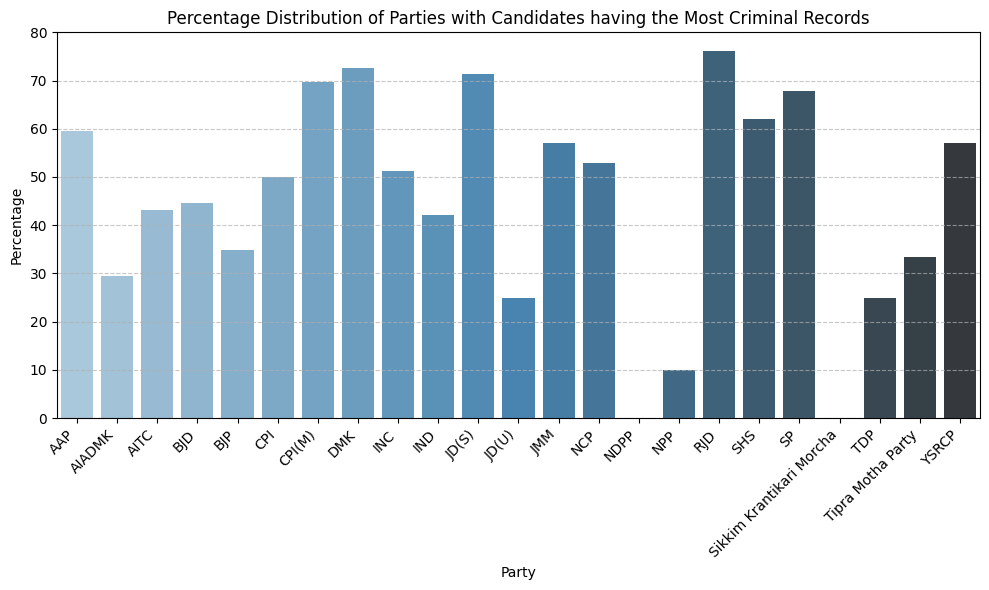

In [82]:
total_candidates_per_party = train_data.groupby('Party').size()
candidates_with_criminal_records_per_party = train_data[train_data['Criminal Case'] > 0].groupby('Party').size()
percentage_distribution = (candidates_with_criminal_records_per_party / total_candidates_per_party) * 100
percentage_distribution = percentage_distribution.reset_index(name='Percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='Party', y='Percentage', data=percentage_distribution, palette='Blues_d')
plt.title('Percentage Distribution of Parties with Candidates having the Most Criminal Records')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-83-96bb4a0a60db>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Party', y='Percentage wrt Total Assets', data=percentage_distribution, palette='Blues_d')


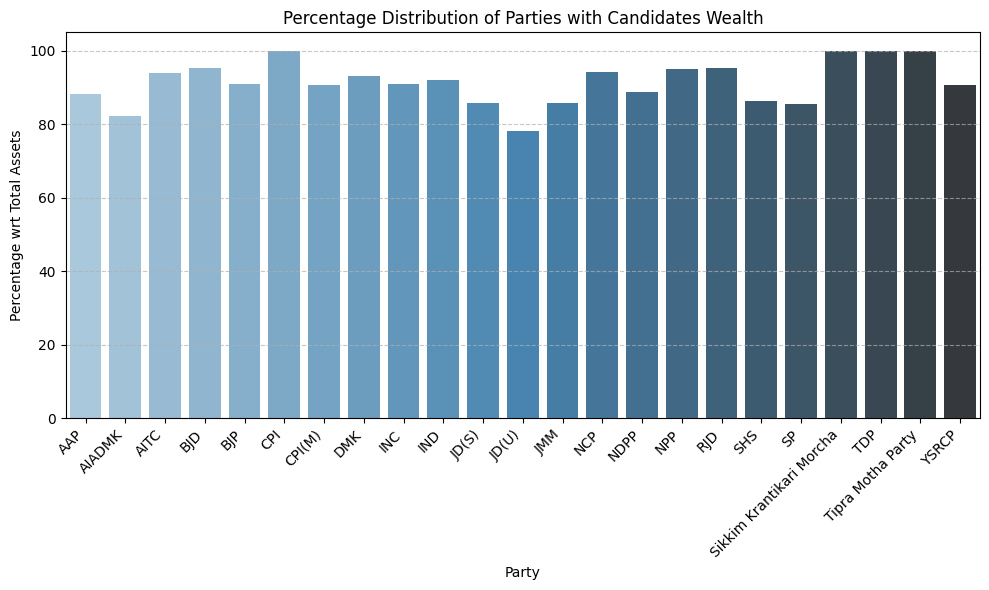

In [83]:
total_candidates_per_party = train_data.groupby('Party').size()
candidates_wealth_per_party = train_data[train_data['Total Assets'] > 0].groupby('Party').size()
percentage_distribution = (candidates_wealth_per_party / total_candidates_per_party) * 100
percentage_distribution = percentage_distribution.reset_index(name='Percentage wrt Total Assets')

plt.figure(figsize=(10, 6))
sns.barplot(x='Party', y='Percentage wrt Total Assets', data=percentage_distribution, palette='Blues_d')
plt.title('Percentage Distribution of Parties with Candidates Wealth')
plt.xlabel('Party')
plt.ylabel('Percentage wrt Total Assets')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

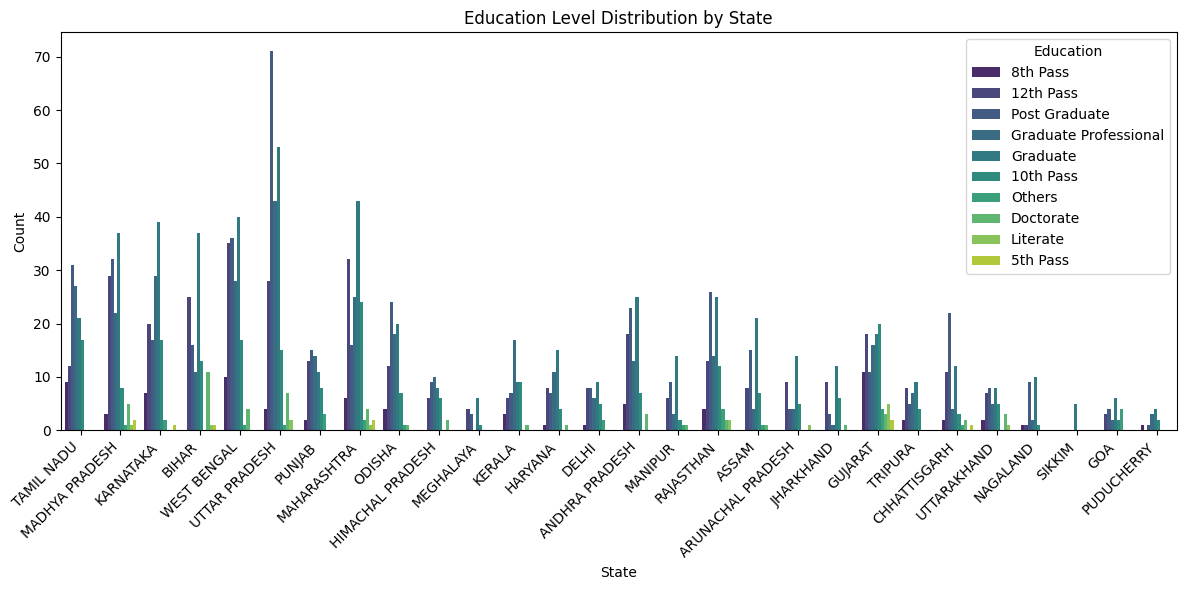

In [84]:
plt.figure(figsize=(12, 6))

sns.countplot(x='state', hue='Education', data=train_data, palette='viridis')

plt.xticks(rotation=45, ha='right')

plt.title('Education Level Distribution by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

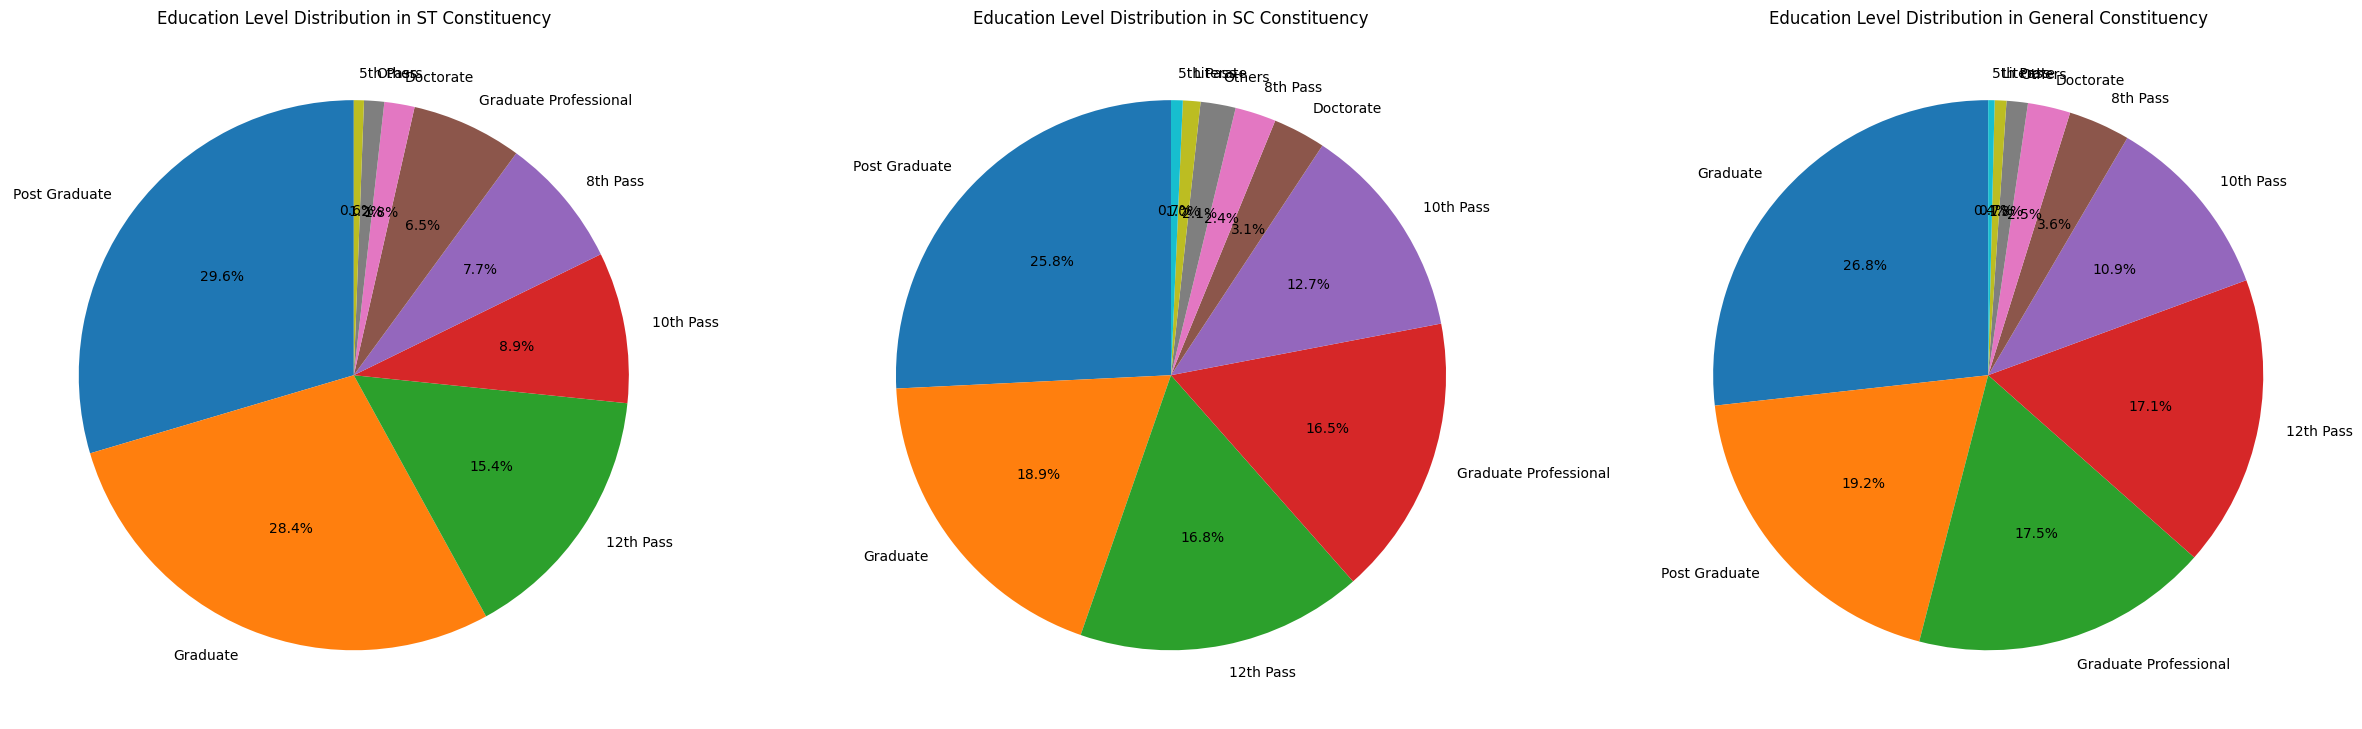

In [85]:
new_df = train_data.melt(id_vars='Education', value_vars=['ST_Constituency', 'SC_Constituency', 'General_Constituency'],
                             var_name='Constituency_Type', value_name='Presence')

new_df = new_df[new_df['Presence'] == 1]

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for ax, constituency_type in zip(axes, ['ST', 'SC', 'General']):
    education_counts = new_df[new_df['Constituency_Type'] == f'{constituency_type}_Constituency']['Education'].value_counts()
    ax.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Education Level Distribution in {constituency_type} Constituency')
plt.tight_layout()
plt.show()

<ipython-input-86-4773432c425f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Education', y='Criminal Case', data=train_data, palette='Set1')


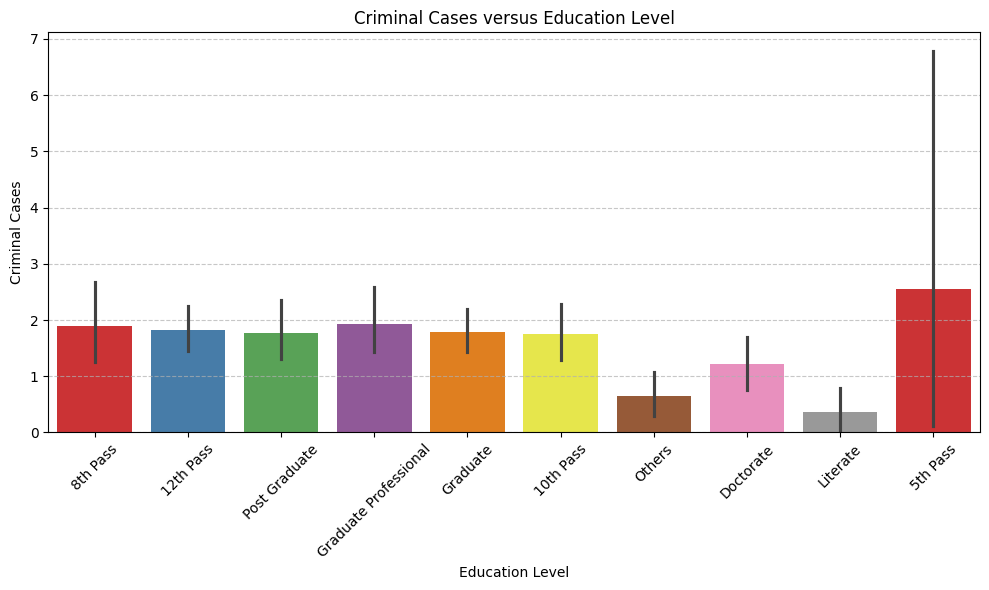

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y='Criminal Case', data=train_data, palette='Set1')
plt.title('Criminal Cases versus Education Level')
plt.xlabel('Education Level')
plt.ylabel('Criminal Cases')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

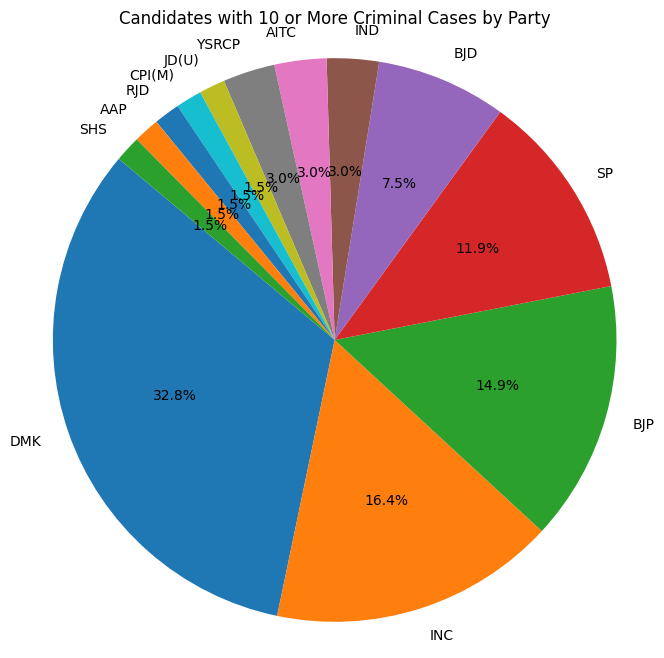

In [87]:
candidates_with_10_or_more_cases = train_data[train_data['Criminal Case'] >= 10]
party_counts = candidates_with_10_or_more_cases['Party'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Candidates with 10 or More Criminal Cases by Party')
plt.axis('equal')
plt.show()


#### Removing unnecessary columns

In [88]:
X = train_data.drop(['Party', 'state', 'Education', 'Constituency ∇'], axis=1)
y = train_data['Education']

test_data.drop(['Party', 'state', 'Constituency ∇'], axis=1, inplace=True)

# Finding Outliers

In [89]:
z_scores = stats.zscore(X)
threshold = 3
outliers = (abs(z_scores) > threshold).any(axis=1)
outliers_ = X[outliers]
print(outliers_)

      Criminal Case  Total Assets  Liabilities  Advocate  Doctor  \
0                 4  2.110000e+09   20000000.0         0       0   
1                 0  1.000000e+07          0.0         0       0   
2                 0  7.000000e+07    2200000.0         0       1   
3                 0  9.000000e+07    2400000.0         0       0   
4                 2  2.000000e+07    6100000.0         0       0   
...             ...           ...          ...       ...     ...   
2054              1  6.100000e+06    1000000.0         0       0   
2055              0  2.000000e+07     800000.0         0       0   
2056              0  1.300000e+08    8500000.0         0       1   
2057              1  2.500000e+08    9400000.0         0       0   
2058              0  1.100000e+06          0.0         0       0   

      ANDHRA PRADESH  ARUNACHAL PRADESH  ASSAM  BIHAR  CHHATTISGARH  ...  \
0                  0                  0      0      0             0  ...   
1                  0           

In [90]:
train_data = train_data[abs(z_scores) <= threshold]

# SMOTE for over sampling

In [91]:
from imblearn.over_sampling import SMOTE

desired_samples = {'Graduate': 1500, 'Post Graduate': 1300, '12th Pass':1000,
                     'Graduate Professional':1300, '10th Pass':1000, '8th Pass':400, 'Doctorate':400}

smote = SMOTE(sampling_strategy=desired_samples)

X_new, y_new = smote.fit_resample(X, y)
X= pd.DataFrame(X_new, columns=X.columns)
y = y_new

print(y.value_counts())

Education
Graduate                 1500
Post Graduate            1300
Graduate Professional    1300
12th Pass                1000
10th Pass                1000
8th Pass                  400
Doctorate                 400
Others                     28
Literate                   14
5th Pass                    9
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1500) in class Graduate will be larger than the number of samples in the majority class (class #Graduate -> 531)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1300) in class Post Graduate will be larger than the number of samples in the majority class (class #Graduate -> 531)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1000) in class 12th Pass will be larger than the number of samples in the majority class (class #Graduate -> 531)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1300) in class Graduate Professional will be larger than the number of sampl

# Selecting the K best features (Dimensionality Reduction)

In [92]:
k = 40
selector = SelectKBest(score_func=f_classif, k=k)

X_selected = selector.fit_transform(X,y)

selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

print("Selected features:")
print(selected_features)

X = pd.DataFrame(X_selected, columns=selected_features)
test_data = test_data[selected_features]

Selected features:
Index(['Criminal Case', 'Total Assets', 'Advocate', 'Doctor', 'ANDHRA PRADESH',
       'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHHATTISGARH', 'DELHI', 'GOA',
       'GUJARAT', 'KARNATAKA', 'MADHYA PRADESH', 'MAHARASHTRA', 'NAGALAND',
       'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'UTTAR PRADESH', 'AAP',
       'BJP', 'CPI', 'DMK', 'INC', 'NPP', 'SHS', 'SP',
       'Sikkim Krantikari Morcha', 'Net Capital', 'Region_Central',
       'Region_East', 'Region_North East', 'Region_South', 'Region_West',
       'ST_Constituency', 'SC_Constituency', 'General_Constituency',
       'Party_Type'],
      dtype='object')


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=48)

In [ ]:
# X_train.drop(['Liabilities','NDPP','TDP','JD(S)','Sikkim Krantikari Morcha','CPI','Tipra Motha Party'], axis=1, inplace=True)
# X_test.drop(['Liabilities','NDPP','TDP','JD(S)','Sikkim Krantikari Morcha','CPI','Tipra Motha Party'], axis=1, inplace=True)
# test_data.drop(['Liabilities','NDPP','TDP','JD(S)','Sikkim Krantikari Morcha','CPI','Tipra Motha Party'], axis=1, inplace=True)

# Printing to check data

In [95]:
X.head()

,Criminal Case,Total Assets,Advocate,Doctor,ANDHRA PRADESH,ARUNACHAL PRADESH,ASSAM,BIHAR,CHHATTISGARH,DELHI,...,Net Capital,Region_Central,Region_East,Region_North East,Region_South,Region_West,ST_Constituency,SC_Constituency,General_Constituency,Party_Type
0,4.0,2.110000e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.090000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.0,1.000000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e+07,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,7.000000e+07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.780000e+07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,9.000000e+07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,8.760000e+07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,2.000000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390000e+07,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [96]:
X_train.head()

,Criminal Case,Total Assets,Advocate,Doctor,ANDHRA PRADESH,ARUNACHAL PRADESH,ASSAM,BIHAR,CHHATTISGARH,DELHI,...,Net Capital,Region_Central,Region_East,Region_North East,Region_South,Region_West,ST_Constituency,SC_Constituency,General_Constituency,Party_Type
6175,0.0,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.800000e+06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5166,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.081769e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6154,1.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.000000e+07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3032,1.0,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.558114e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.200000e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
X_test.head()

,Criminal Case,Total Assets,Advocate,Doctor,ANDHRA PRADESH,ARUNACHAL PRADESH,ASSAM,BIHAR,CHHATTISGARH,DELHI,...,Net Capital,Region_Central,Region_East,Region_North East,Region_South,Region_West,ST_Constituency,SC_Constituency,General_Constituency,Party_Type
6403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.676855e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4717,0.0,40000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.149387e+07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
465,7.0,430000000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.700000e+08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
827,12.0,70000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.000000e+07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.400000e+06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [98]:
y_train.head()

6175            Post Graduate
5166    Graduate Professional
6154            Post Graduate
3032                12th Pass
3307                12th Pass
Name: Education, dtype: object

# Scaling to improve prediction

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Hyper-parameter tuning to find the best parameters for any given model

### Takes in input the model and its range of various parameters to check and find from the best parameters.

In [101]:
def train_and_evaluate_model(model, params_grid, X_train, y_train, X_test, y_test, test_data):

    grid_search = GridSearchCV(model, params_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)
    best_parameters = grid_search.best_params_
    print('Best parameters: ', best_parameters)

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(report)

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    y_pred_test = best_model.predict(test_data)
    df_submission = pd.DataFrame({'ID': range(len(y_pred_test)), 'Education': y_pred_test})
    df_submission.to_csv('submission.csv', index=False)

    return best_model

# Decision Trees Classifier Model

In [102]:
from sklearn.tree import DecisionTreeClassifier

params_grid_DT = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [9,10, 11, 12,13,14,15,16],
}

best_DT_model = train_and_evaluate_model(DecisionTreeClassifier(), params_grid_DT, X_train, y_train, X_test, y_test, test_data)

Best parameters:  {'criterion': 'entropy', 'max_depth': 16, 'splitter': 'best'}
                       precision    recall  f1-score   support

            10th Pass       0.53      0.54      0.53       140
            12th Pass       0.46      0.45      0.46       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.47      0.44      0.46        43
            Doctorate       0.59      0.71      0.65        42
             Graduate       0.50      0.49      0.50       196
Graduate Professional       0.48      0.55      0.51       164
             Literate       0.00      0.00      0.00         1
               Others       0.00      0.00      0.00         5
        Post Graduate       0.57      0.50      0.53       198

             accuracy                           0.51       904
            macro avg       0.36      0.37      0.36       904
         weighted avg       0.51      0.51      0.51       904

Confusion Matrix:
[[75 12  1  3  2 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: Use

# Random Forest Classifier Model

In [106]:
from sklearn.ensemble import RandomForestClassifier

params_grid_RF = {
    # 'n_estimators' : [90,100,150,200],
    # 'criterion' : ['gini','entropy','log_loss'],
    'max_depth' : [10,11,12,13,14 ],
    # 'min_samples_split' : [7, 9, 10, 11, 13],
}

best_RF_model = train_and_evaluate_model(RandomForestClassifier(random_state=42), params_grid_RF, X_train, y_train, X_test, y_test, test_data),

Best parameters:  {'max_depth': 14}
                       precision    recall  f1-score   support

            10th Pass       0.57      0.36      0.44       140
            12th Pass       0.42      0.28      0.34       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.60      0.21      0.31        43
            Doctorate       0.68      0.62      0.65        42
             Graduate       0.39      0.46      0.42       196
Graduate Professional       0.34      0.55      0.42       164
             Literate       0.00      0.00      0.00         1
               Others       0.00      0.00      0.00         5
        Post Graduate       0.46      0.43      0.44       198

             accuracy                           0.42       904
            macro avg       0.35      0.29      0.30       904
         weighted avg       0.45      0.42      0.42       904

Confusion Matrix:
[[51 12  0  0  1 28 24  0  0 24]
 [ 9 32  0  0  0 24 35  0  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: Use

# Bernoulli NB Classifier Model

In [105]:
from sklearn.naive_bayes import BernoulliNB

params_grid_BNB = {
    'alpha' : [0.1,0.3,0.4,0.5,0.6,0.7,1.0, 1.3, 1.6,2.0, 2.1, 2.2,2.4,2.5,2.6],
    'force_alpha': [True, False],
    'fit_prior': [True, False],
    'binarize' : [0.0,0.1]
}

best_BNB_model = train_and_evaluate_model(BernoulliNB(), params_grid_BNB, X_train, y_train, X_test, y_test, test_data)

Best parameters:  {'alpha': 1.6, 'binarize': 0.0, 'fit_prior': True, 'force_alpha': True}
                       precision    recall  f1-score   support

            10th Pass       0.28      0.09      0.14       140
            12th Pass       0.22      0.12      0.15       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.10      0.02      0.04        43
            Doctorate       0.58      0.33      0.42        42
             Graduate       0.30      0.36      0.33       196
Graduate Professional       0.27      0.44      0.33       164
             Literate       0.00      0.00      0.00         1
               Others       0.00      0.00      0.00         5
        Post Graduate       0.32      0.41      0.36       198

             accuracy                           0.29       904
            macro avg       0.21      0.18      0.18       904
         weighted avg       0.29      0.29      0.27       904

Confusion Matrix:
[[13 11

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: Use

# SVC Classifier Model

In [107]:
from sklearn.svm import SVC

params_grid_SVC = {
    'C': [ 0.01, 0.1, 1,5,7, 10, 12,15,18],
    # 'kernel' : ['linear', 'poly', 'sigmoid'],
    'tol': [0.001, 0.01, 0.1]
}

best_SVC_model = train_and_evaluate_model(SVC(random_state=42), params_grid_SVC, X_train, y_train, X_test, y_test, test_data)

Best parameters:  {'C': 18, 'tol': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: Use

                       precision    recall  f1-score   support

            10th Pass       0.23      0.10      0.14       140
            12th Pass       0.20      0.07      0.10       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.22      0.05      0.08        43
            Doctorate       0.43      0.48      0.45        42
             Graduate       0.32      0.32      0.32       196
Graduate Professional       0.27      0.48      0.35       164
             Literate       0.00      0.00      0.00         1
               Others       0.00      0.00      0.00         5
        Post Graduate       0.31      0.41      0.36       198

             accuracy                           0.30       904
            macro avg       0.20      0.19      0.18       904
         weighted avg       0.28      0.30      0.27       904

Confusion Matrix:
[[14  7  0  0  8 33 36  0  0 42]
 [ 9  8  0  0  3 28 41  0  0 24]
 [ 1  0  0  0  0  1  0  0  0  0

# K Nearest Neighbours Classifier

In [104]:
from sklearn.neighbors import KNeighborsClassifier

params_grid_KNN = {
    'n_neighbors': [3, 5 ,6,7, 8, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
}

best_KNN_model = train_and_evaluate_model(KNeighborsClassifier(), params_grid_KNN, X_train, y_train, X_test, y_test, test_data)

Best parameters:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
                       precision    recall  f1-score   support

            10th Pass       0.51      0.51      0.51       140
            12th Pass       0.35      0.45      0.40       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.42      0.42      0.42        43
            Doctorate       0.56      0.81      0.66        42
             Graduate       0.52      0.46      0.49       196
Graduate Professional       0.45      0.45      0.45       164
             Literate       0.00      0.00      0.00         1
               Others       0.00      0.00      0.00         5
        Post Graduate       0.52      0.46      0.49       198

             accuracy                           0.48       904
            macro avg       0.33      0.36      0.34       904
         weighted avg       0.48      0.48      0.47       904

Confusion Matrix:
[[71 18  0  2 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Gradient Boosting Classifier Model

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

params_grid_GDB = {
    # 'loss':['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 1,10],
    # 'n_estimators':[100, 500, 1000],
}

best_GDB_model = train_and_evaluate_model(GradientBoostingClassifier(random_state = 42), params_grid_GDB, X_train, y_train, X_test, y_test, test_data)

Best parameters:  {'learning_rate': 0.1}
                       precision    recall  f1-score   support

            10th Pass       0.44      0.34      0.39       140
            12th Pass       0.35      0.19      0.24       113
             5th Pass       0.00      0.00      0.00         2
             8th Pass       0.39      0.33      0.35        43
            Doctorate       0.59      0.52      0.56        42
             Graduate       0.35      0.47      0.40       196
Graduate Professional       0.34      0.44      0.38       164
             Literate       0.00      0.00      0.00         1
               Others       0.20      0.20      0.20         5
        Post Graduate       0.42      0.39      0.41       198

             accuracy                           0.38       904
            macro avg       0.31      0.29      0.29       904
         weighted avg       0.39      0.38      0.38       904

Confusion Matrix:
[[48 10  0  2  0 36 18  0  1 25]
 [12 21  0  2  1 35 26 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: Use

#### Thank you!!